In [62]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

class MonteCarloOptionPricing:
    def __init__(self, r, S0: float, K: float, T: float, σ: float, dim: int, n: int, seed: int, use_AV: bool = False):
        """ Class for pricing American Options using LSM. 
        
        Parameters: 
        r (float): Risk-free interest rate
        S0 (float): Initial asset value
        K (float): Strike price
        T (float): Time to maturity, in years
        σ (float): Volatility coefficient for diffusion
        dim (int): Number of paths to simulate
        n (int): Number of time steps between time 0 and time T
        seed (int): Random seed for reproducibility
        use_AV (bool): Flag to use Antithetic Variates method (default: False)
        """
        
        assert σ >= 0, 'Volatility cannot be less than zero'
        assert S0 >= 0, 'Initial stock price cannot be less than zero'
        assert T >= 0, 'Time to maturity cannot be less than zero'
        assert n >= 0, 'Number of slices per year cannot be less than zero'
        assert dim >= 0, 'Number of simulation paths cannot be less than zero'
        
        # Set the random seed for reproducibility
        np.random.seed(seed)
        
        self.r = r
        self.S0 = S0
        self.K = K
        self.T = T
        self.σ = σ
        self.n = n
        self.Δ = self.T / self.n
        self.df = np.exp(-self.r * self.Δ)
        self.use_AV = use_AV
        self.dim = dim

        if use_AV:
            assert dim % 2 == 0, 'For AV, the number of paths (dim) must be even'
            half_dim = dim // 2
            Z_half = np.random.normal(0, 1, (half_dim, self.n - 1)) #Z_half matrix with dimension (half_dim, self.n-1), representing random increments of the asset´s price over time for half the paths'
            self.Z = np.concatenate((Z_half, -Z_half), axis=0)  # Antithetic variates. Creating full matrix self:Z by concatenating Z_half with its negation -Z.half.
        else:
            self.Z = np.random.normal(0, 1, (dim, self.n - 1))  # Original method

        self.S = np.full((dim, self.n), np.nan)  # Allocate space for stock price process

    def GeometricBrownianMotion(self):
        """ Generate GBM paths according to Algorithm 3.
        
        Returns:
        np.ndarray: Simulated paths of the asset price.
        """
        
        # unpack parameters
        Δ = self.Δ
        Z = self.Z
        S = self.S
        S0 = self.S0
        r = self.r
        σ = self.σ
        n = self.n
        
        S[:,0] = np.log(S0)  # Set initial values
        for j in range(1,n):
            S[:,j] = S[:,j-1] + (r-0.5*σ**2)*Δ + σ*np.sqrt(Δ)*Z[:,j-1]
            
        self.S = np.exp(S)  # Exponentiate to get the GBM paths
        return self.S
    
    ##########################
    ### Vectorized Version ###
    ##########################
    def GeometricBrownianMotion_vec(self):
        """ Generate GBM paths according to Algorithm 3.

        Returns:
        np.ndarray: Simulated paths of the asset price.
        """

        # unpack parameters
        Δ = self.Δ
        Z = self.Z
        S = self.S
        S0 = self.S0
        r = self.r
        σ = self.σ
        n = self.n

        # Generate all increments at once
        BM = (r - 0.5*σ**2)*Δ + σ*np.sqrt(Δ)*Z
        
        # Use cumsum to calculate the cumulative sum of increments and then exponentiate
        S[:,:] = np.log(S0)
        S[:,1:] += np.cumsum(BM, axis=1)

        # Multiply every path by the initial stock price
        self.S = np.exp(S)
        return self.S
    
    def MertonJumpDiffusion(self,α: float, β: float, λ: float):
        """
        Generate Merton Jump Diffusion paths according to Algorithm 4 assuming log-normal distribution of shocks.
        Parameters:
        α (float): Mean of log-normal jump size
        β (float): Volatility of log-normal jump size
        λ (float): Intensity rate of the Poisson process
        
        Returns:
        np.ndarray: Simulated paths of the asset price
        """
        self.α = α
        self.β = β
        self.λ = λ
        
        # unpack parameters
        Δ = self.Δ
        Z = self.Z
        S = self.S
        S0 = self.S0
        r = self.r
        σ = self.σ
        n = self.n
        α = self.α
        β = self.β
        λ = self.λ
        dim = self.dim

        S[:,0] = np.log(S0) 
        c = r - 0.5*σ**2 - λ*(np.exp(α + 0.5*β**2) - 1)
        
        # Generate Poisson and (log-)normal random jumps for all paths and time steps at once
        N = np.random.poisson(λ*Δ, (dim, n-1))  # Poisson process for the number of jumps
        Z_2 = np.random.normal(0, 1, (dim, n-1))  # Normal random variables for the jump sizes
        
        for j in range(1,n):
            # Compute jump sizes for each path
            M = α*N[:,j-1] + β*np.sqrt(N[:,j-1])*Z_2[:,j-1]
            # if no jump set jump process to zero 
            M = np.where(N[:,j-1] > 0, M, 0)
            # Calculate the combined diffusion and jump process
            S[:,j] = S[:,j-1] + c*Δ + σ*np.sqrt(Δ)*Z[:,j-1] + M
            
        self.S = np.exp(S) 
    
        return self.S
    
    ##########################
    ### Vectorized Version ###
    ##########################
    def MertonJumpDiffusion_vec(self, α: float, β: float, λ: float):
        """
        Generate Merton Jump Diffusion paths according to Algorithm 4 assuming log-normal distribution of shocks.
        Parameters:
        α (float): Mean of log-normal jump size
        β (float): Volatility of log-normal jump size
        λ (float): Intensity rate of the Poisson process
        
        Returns:
        np.ndarray: Simulated paths of the asset price
        """
        self.α = α
        self.β = β
        self.λ = λ
        
        # unpack parameters
        Δ = self.Δ
        Z = self.Z
        S = self.S
        S0 = self.S0
        r = self.r
        σ = self.σ
        n = self.n
        α = self.α
        β = self.β
        λ = self.λ
        dim = self.dim
        
        # No changes up to the definition of c
        c = r - 0.5*σ**2 - λ*(np.exp(α + 0.5*β**2) - 1)

        # Generate Poisson and (log-)normal random jumps for all paths and time steps at once
        N = np.random.poisson(λ*Δ, (dim, n-1))  # Poisson process for the number of jumps
        Z_2 = np.random.normal(0, 1, (dim, n-1))  # Normal random variables for the jump sizes

        # Calculate the jump sizes for all paths and time steps
        M = α * N + β*np.sqrt(N)*Z_2
        
        # if no jump set M = 0
        M = np.where(N > 0, M, 0)
        
        # Calculate the combined diffusion and jump process for all time steps
        S[:,:] = np.log(S0)
        S[:,1:] = np.log(S0) + np.cumsum(c*Δ + σ*np.sqrt(Δ)*Z + M, axis=1)

        self.S = np.exp(S)

        return self.S

    def CEV(self,γ: float):
        """
        Generate CEV paths according to Algorithm 5. 
        
        Parameters:
        γ (float): parameter governing elasticity with respect to price
        
        Returns:
        np.ndarray: Simulated paths of the asset price
        """ 
        assert γ>= 0, 'cant let elasticity be negative due to leverage effect'
        self.γ = γ

        # unpack parameters
        Δ = self.Δ
        Z = self.Z
        S = self.S
        S0 = self.S0
        r = self.r
        γ = self.γ
        σ = self.σ
        n = self.n

        S[:,0] = S0  # Set initial values
        # Simulation using the Euler-Maruyama method for the CEV model
        for j in range(1,n):
            S[:,j] = S[:,j-1] + r*S[:,j-1]*Δ + σ*S[:,j-1]**(γ/2)*np.sqrt(Δ)*Z[:,j-1]
        self.S = S

        return self.S
    
    
    def BS_option_value(self, otype: str = 'put'):
        ''' Closed-form valuation of a European option in Black-Scholes.
        
        Parameters:
        otype (str): Option type either call or put (defualt: put)
        
        Returns:
        float: Option price of a European put option
        '''
        
        # unpack 
        S0 = self.S0
        K = self.K
        r = self.r
        σ = self.σ
        T = self.T

        d1 = (np.log(S0/K) + (r + 0.5*σ**2)*T) / (σ*np.sqrt(T))
        d2 = d1 - σ*np.sqrt(T)
        
        if otype == 'call':
            value = (S0 * stats.norm.cdf(d1, 0., 1.) -
                 K * np.exp(-r * T)*stats.norm.cdf(d2, 0., 1.))
        elif otype == 'put':
            value = K * np.exp(-r*T)*stats.norm.cdf(-d2) - S0*stats.norm.cdf(-d1)
        else: 
            raise ValueError('Invalid option type.')
    
        return value
    def american_option_LSM(self, poly_degree: int, otype: str = 'put'):
        """
        American option pricing using the LSM as outlined in Algorithm 1.
        
        Parameters:
        poly_degree (int): x^n, number of basis functions
        otype (str): call or put (default)
        
        Returns:
        float: V0, LSM Estimator
        np.ndarray: Exercise times for each path (in case of early exercise)
        """
        
        assert otype == 'call' or otype == 'put', 'Invalid option type.'
        assert len(self.S) != 0, 'Please simulate a stock price process.'
        
        # unpack
        S = self.S
        K = self.K
        S0 = self.S0
        n = self.n
        dim = self.dim
        df = self.df
        
        # Initialize exercise_times array to store exercise times for each path
        exercise_times = np.full(dim, self.T)  # Initialize with T (no exercise)
        
        # Initialize an array to store payoffs
        payoffs = np.zeros(dim)

        # inner values
        if otype == 'call':
            self.intrinsic_val = np.maximum(S - K, 0)
        elif otype == 'put':
            self.intrinsic_val = np.maximum(K - S, 0)
            
        # last day cashflow == last day intrinsic value
        V = np.copy(self.intrinsic_val[:,-1])

        # Backward Induction
        for i in range(n - 2, 0, -1): # start at second to last and end at second to first
            # a. find itm path 
            # (potentially) better estimate the continuation value
            itm_path = np.where(self.intrinsic_val[:,i] > 0)  # evaluate: S[:,i] vs. K
            V = V * df # discount next period value
            V_itm = V[itm_path[0]] # define subset (note, we need to set [0] due to np.where being tuple)
            S_itm = S[itm_path[0],i]
            
            # b. run regression and calculate conditional expectation (LSM)
            # initialize continuation value
            C = np.zeros(shape=dim)
            # if only 5 itm paths (probably, otm options), then continuation value is zero
            if len(itm_path[0]) > 5:
                rg = np.polyfit(S_itm, V_itm, poly_degree)  # polynomial regression
                C[itm_path[0]] = np.polyval(rg, S_itm)  # evaluate conditional expectation
            
            # c. Calculation of value function at i 
            # if hold: V = 0, if exercise: V = intrinsic value
            exercise_condition = self.intrinsic_val[:, i] > C
            V = np.where(exercise_condition, self.intrinsic_val[:, i], V)
            
            for idx in np.where(exercise_condition)[0]:
                payoffs[idx] = self.intrinsic_val[idx, i]
                exercise_times[idx] = i * self.Δ
            
            # Update exercise times for paths that exercised
            exercise_times[exercise_condition] = i * self.Δ
            
        self.V0 = df * np.average(V)
        
        return self.V0, exercise_times
    def plot_paths(self):
        """
        Plot simulated stock price paths along with the mean path.
        """
        # Define time interval
        time = np.linspace(0, self.T, self.n)  # Ensure to include the initial time step

        # Calculate the mean of the paths at each time step
        mean_path = np.mean(self.S, axis=0)

        # Plot
        plt.figure(figsize=(10, 6))
        
        plt.plot(time, self.S.T, lw=1, alpha=0.25)

        # Plot the mean path with a higher alpha and a different color for visibility
        plt.plot(time, mean_path, 'b', lw=2, alpha=0.75, label='Mean Path')

        plt.xlabel("Time, $t$")
        plt.ylabel("Stock Price, $S_t$")
        plt.title(f'{self.dim} Stock Price Simulation Paths')
        plt.legend()
        
        plt.show()
        
    
        


In [64]:
# Initialize the Monte Carlo pricer
mc_option_pricing = MonteCarloOptionPricing(r=0.06, S0=36., K=40., T=1., σ=0.2, dim=100000, n=50, seed=150_000)

# Generate the simulated paths
simulated_paths = mc_option_pricing.GeometricBrownianMotion_vec()

# Run the LSM algorithm to price the American option
mc_option_pricing.american_option_LSM(poly_degree=3, otype='put')

# Access and print the payoffs
#print("Individual Payoffs:", payoffs)

# If you want to verify that the average is correct
#print("Average Payoff:", average_payoff)


In [65]:
mc_option_pricing.american_option_LSM(poly_degree=3, otype='put')



(4.457498419908849, array([1.  , 0.06, 0.74, ..., 1.  , 1.  , 0.4 ]))

In [16]:
# Initialize your MonteCarloOptionPricing instance with desired parameters
mc_option_pricing = MonteCarloOptionPricing(r=0.06, S0=36., K=40., T=1., σ=0.2, dim=1000, n=50, seed=150000, use_AV=True)
mc_option_pricing.GeometricBrownianMotion_vec()

# Calculate American option price and exercise times
american_price, exercise_times = mc_option_pricing.american_option_LSM(poly_degree=3, otype='put')

# Print exercise times
print("Exercise Times:")
print(exercise_times)

averagetime = np.mean(exercise_times)
print(averagetime)

Exercise Times:
[1.   0.1  0.74 0.22 1.   0.34 0.2  1.   1.   0.3  0.9  0.66 0.18 1.
 1.   1.   1.   0.12 1.   0.42 1.   1.   0.22 0.88 0.06 1.   0.3  0.12
 0.3  1.   0.22 0.26 0.46 0.2  0.12 0.18 0.28 0.2  0.14 0.12 0.28 1.
 1.   0.12 1.   1.   0.18 0.28 0.42 0.3  1.   0.12 0.66 1.   0.28 0.14
 1.   1.   0.12 1.   0.18 1.   0.22 0.3  1.   0.22 0.12 0.18 0.12 0.18
 0.2  0.14 0.22 0.28 0.42 0.18 1.   0.3  0.2  0.54 1.   0.12 1.   0.14
 0.74 1.   0.12 1.   1.   0.28 0.3  1.   0.42 0.46 0.14 0.84 0.3  1.
 0.22 0.26 0.6  1.   1.   0.46 1.   1.   0.12 0.24 0.12 1.   0.2  0.62
 0.3  1.   0.22 1.   1.   0.22 0.3  1.   0.7  0.68 0.84 0.28 0.64 1.
 1.   0.84 0.54 0.52 1.   1.   1.   0.24 0.18 1.   1.   1.   0.28 0.24
 1.   1.   1.   0.66 0.5  1.   0.14 0.28 0.3  0.2  1.   1.   0.24 0.68
 0.22 0.84 1.   0.12 1.   0.52 0.54 0.52 0.56 0.54 1.   0.3  1.   0.34
 1.   1.   0.14 1.   1.   0.2  1.   0.3  0.12 0.18 0.12 1.   0.38 0.12
 1.   1.   0.2  0.46 0.12 0.12 0.2  0.3  0.14 0.2  0.34 0.9  0.3  1.


# 1. Control Variates Sampling at Expiry

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
# Inputs
dim = 10
n = 252
T = 1
σ = 0.25
K = 40
r = 0.04
S0 = 38
seed = 5
#hans n = vores dim
#hans M = vores n
#hans sigma = vores σ

# Initialize the Monte Carlo pricer
mc_option_pricing = MonteCarloOptionPricing(r, S0, K, T, σ, dim, n, seed)

# Simulation of GBM
#Z = np.random.normal(0, 1, size=(dim, n))
#S = np.exp(
#    np.cumsum((r - 0.5 * (σ ** 2)) * (T / n) + σ * np.sqrt(T / n) * Z, axis=1)
#    + np.log(S0)
#)


simulated_paths = mc_option_pricing.GeometricBrownianMotion_vec()

# Run the LSM algorithm to price the American option
mc_option_pricing.american_option_LSM(poly_degree=3, otype='put')

# Access and print the payoffs
American_payoffs = mc_option_pricing.V
print("Individual Payoffs:", American_payoffs)

Control_payoffs = np.exp(-r * T) * np.maximum(K - mc_option_pricing.S[:, -1], 0) #European put
print(Control_payoffs)





Individual Payoffs: [ 2.67252875  1.41747994  1.4959064   2.14244655  2.82737323  0.7676343
 11.77888195  2.53654765  2.15128837  4.40741401]
[ 2.193707    0.          8.77709725  0.          0.          0.
 19.34948938  0.90649933 15.55140516  7.47735815]


In [54]:
mc_option_pricing.S[:,-1]

array([37.806293  , 46.55055625, 31.22290275, 68.09875307, 47.44550507,
       43.88896484, 20.65051062, 39.09350067, 24.44859484, 32.52264185])

Now, the prices (averaging over the previously payoffs)

In [55]:
# Estimate prices by crude Monte Carlo
American_price_est = np.mean(American_payoffs)
Control_price_est = np.mean(Control_payoffs)
print(American_price_est)
print(Control_price_est)
print(len(American_payoffs), len(Control_payoffs))  # Both should be equal to n


3.2197501148017573
5.425555627330515
10 10


Correlation Coefficient
-0.6233615748411186
SquaredCorr.
0.3885796529883996
Control variate price estimate
59.342494872984034
Variance ratio of payoffs (VAmerican/VControlVariate)
1.6228033030972389


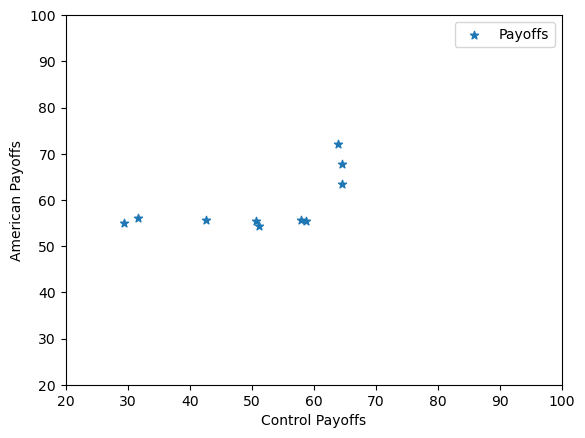

In [44]:
# Plots payoffs to show correlation
plt.scatter(Control_payoffs, American_payoffs, marker='*', label='Payoffs')
plt.xlabel('Control Payoffs')
plt.ylabel('American Payoffs')
plt.legend()

# Set axis limits
x_min, x_max = 20, 100  # Replace with your desired min and max for the x-axis
y_min, y_max = 20, 100  # Replace with your desired min and max for the y-axis

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

# Control mean (Calculated using Black-Scholes)
d1 = (1 / (σ * np.sqrt(T))) * (np.log(S0 / K) + (r + 0.5 * σ ** 2) * T)
d2 = d1 - σ * np.sqrt(T)
Control_mean = K * np.exp(-r * T) * norm.cdf(-d2) - S0 * norm.cdf(-d1)

# Calculates Y_i's
covariance = np.cov([American_payoffs, Control_payoffs], ddof=0)
thetaaa = -np.cov(American_payoffs,Control_payoffs)[0,1]/np.var(Control_payoffs) #OLS estimation of theta
Y = American_payoffs + thetaaa * (Control_payoffs - Control_mean)

# Prints correlation coefficient
#print('Correlation of payoffs')
rho = -np.corrcoef(American_payoffs, Control_payoffs)[0, 1]
print('Correlation Coefficient')
print(rho)
squaredcorr = rho**2
print("SquaredCorr.")
print(squaredcorr)

# Price est using control variate
print('Control variate price estimate')
print(np.mean(Y))

# Checks variances
print('Variance ratio of payoffs (VAmerican/VControlVariate)')
var_ratio = np.var(American_payoffs) / np.var(Y)
print(var_ratio)
#print(Y)


# 2. Control Variates sampled at Exercise

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
# Inputs
dim = 20000
n = 252
T = 1
σ = 0.25
K = 96
r = 0.04
S0 = 40
seed = 5
#hans n = vores dim
#hans M = vores n
#hans sigma = vores σ

# Initialize the Monte Carlo pricer
mc_option_pricing = MonteCarloOptionPricing(r, S0, K, T, σ, dim, n, seed)

# Simulation of GBM
Ze = np.random.normal(0, 1, size=(dim, n))
Se = np.exp(
    np.cumsum((r - 0.5 * (σ ** 2)) * (0.5266 / n) + σ * np.sqrt(0.5266 / n) * Z, axis=1)
    + np.log(S0)
)


simulated_pathse = mc_option_pricing.GeometricBrownianMotion_vec()

# Run the LSM algorithm to price the American option
mc_option_pricing.american_option_LSM(poly_degree=3, otype='put')

# Access and print the payoffs
American_payoffse = mc_option_pricing.V
#print("Individual Payoffs:", American_payoffs)

Control_payoffse = np.exp(-r * 0.5266) * np.maximum(K - Se[:, -1], 0)
#print(Control_payoffs)





In [39]:
# Estimate prices by crude Monte Carlo
American_price_este = np.mean(American_payoffse)
Control_price_este = np.mean(Control_payoffse)
print(American_price_este)
print(Control_price_este)
print(len(American_payoffse), len(Control_payoffse))  # Both should be equal to n


55.99292433073957
59.76816004684183
20000 5


The variance reduction factor,  i.e. the ration between the variance obtained by the standard LSM
approach and the variance of the respective control variate estimator. We find this by the inverse of (1-$\rho^2$), where $\rho^2$ is the  estimated squared correlation coefficient

ValueError: operands could not be broadcast together with shapes (20000,) (5,) 

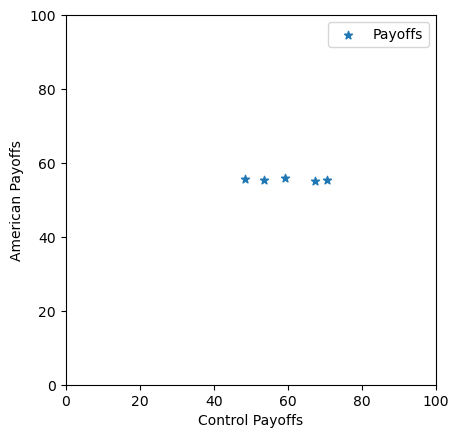

In [40]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

# Assuming Control_payoffs and American_payoffs are defined and contain data

plt.scatter(Control_payoffs, American_payoffs, marker='*', label='Payoffs')
plt.xlabel('Control Payoffs')
plt.ylabel('American Payoffs')
plt.legend()

# Set axis limits
x_min, x_max = 0, 100  # Replace with your desired min and max for the x-axis
y_min, y_max = 0, 100  # Replace with your desired min and max for the y-axis

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

# If you want to keep the aspect ratio equal after setting the axis limits:
plt.gca().set_aspect('equal', adjustable='box')


# Control mean (Calculated using Black-Scholes)
d1e = (1 / (σ * np.sqrt(0.5266))) * (np.log(S0 / K) + (r + 0.5 * σ ** 2) * 0.5266)
d2e = d1e - σ * np.sqrt(0.5266)
Control_meane = K * np.exp(-r * 0.5266) * norm.cdf(-d2) - S0 * norm.cdf(-d1)

# Calculates Y_i's
covariancee = np.cov([American_payoffse, Control_payoffse], ddof=0)
thetaaae = -np.cov(American_payoffse,Control_payoffse)[0,1]/np.var(Control_payoffse) #OLS estimation of theta
Ye = American_payoffse + thetaaae * (Control_payoffse - Control_meane)

# Prints correlation coefficient
#print('Correlation of payoffs')
rhoe = -np.corrcoef(American_payoffse, Control_payoffse)[0, 1]
print('Correlation Coefficient')
print(rhoe)
squaredcorre = rhoe**2
print("SquaredCorr.")
print(squaredcorre)

# Price est using control variate
print('Control variate price estimate')
print(np.mean(Ye))

# Checks variances
print('Variance ratio of payoffs (VAmerican/VControlVariate)')
var_ratioe = np.var(American_payoffse) / np.var(Ye)
print(var_ratioe)
#print(Y)
